In [1]:
import os
import sys

# Workaround to import jaxKAN
project_root = os.path.abspath("..")
sys.path.append(project_root)

from jaxkan.KAN import KAN

import jax
import jax.numpy as jnp

from jaxkan.utils.PIKAN import sobol_sample, gradf

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

import diffrax

In [278]:
class dF_model(nnx.Module):
    def __init__(self,dy_dt):
        self.dy_dt = dy_dt
    def __call__(self, t, y, args):
        # return self.dy_dt(jnp.array([y])).flatten()[0]
        return self.dy_dt(y)#.flatten()[0]

class NeuralODE(nnx.Module):
    def __init__(self,dF):
        self.dF = dF

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.dF),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
            #args=time_features
        )
        result = solution.ys[:, 0, :]  # Removes the singleton middle dimension
        return result

class MLP(nnx.Module):
    def __init__(self, layer_dims, *, rngs: nnx.Rngs):
        self.layers = [
            nnx.Linear(layer_dims[i], layer_dims[i + 1], rngs=rngs) 
            for i in range(len(layer_dims) - 1)
        ]

    def __call__(self, t,y,args):
        for layer in self.layers[:-1]:
            y = layer(y)
            y = jnp.tanh(y)  # Apply tanh activation
        y = self.layers[-1](y)  # Last layer without activation
        return y



In [ ]:
def batch_data(ts,ys,window_size,train_ratio=0.8):
    n_windows = ys.shape[0] // window_size
    batched_ts = ts[:n_windows*window_size].reshape(n_windows, window_size)
    batched_ys = ys[:n_windows*window_size].reshape(n_windows, window_size, -1)

    batches,length_size, data_size = batched_ys.shape #batched_ys[:10,:,:].shape
    #_ts = np.arange(0,length_size,1)

    batch_inds=np.random.choice(range(batches),size=batches,replace=False)
    train_inds = batch_inds[0:int(train_ratio*batches)]
    val_inds = batch_inds[int((1-train_ratio)*batches):]

    train_ts=batched_ts[train_inds]
    train_ys=batched_ys[train_inds,:,:]
    val_ts=batched_ts[val_inds]
    val_ys=batched_ys[val_inds,:,:]
    print(batches,length_size, data_size)
    return train_ts,train_ys,val_ts,val_ys,data_size

In [ ]:
T=np.arange(0,15*np.pi,np.pi/100)#.reshape(-1,1)
window_size = 175
#y=np.array(jnp.cos(T)).reshape(-1,1)
y = np.cos(T).reshape(-1,1)
# Velocity - derivative of position
v = -np.sin(T).reshape(-1,1)

# Combine into a single dataset
ys = np.stack([y, v], axis=1)  # Shape will be [num_samples, 2]
ts, ys = T,jnp.concatenate([y,v],axis=1)

n_windows = ys.shape[0] // window_size
batched_ts = ts[:n_windows*window_size].reshape(n_windows, window_size)
batched_ys = ys[:n_windows*window_size].reshape(n_windows, window_size, -1)

batches,length_size, data_size = batched_ys.shape 

batch_inds=np.random.choice(range(batches),size=batches,replace=False)
train_inds = batch_inds[0:int(0.8*batches)]
val_inds = batch_inds[int(0.2*batches):]

train_ts=batched_ts[train_inds]
train_ys=batched_ys[train_inds,:,:]
val_ts=batched_ts[val_inds]
val_ys=batched_ys[val_inds,:,:]
print(train_ys.shape) 


In [282]:
# Define train loop
@nnx.jit
def train_step(neural_ode_model, optimizer, t_train, y0_train ,y_train):

    def loss_fn(neural_ode_model):
        y_pred = jax.vmap(neural_ode_model, in_axes=(0, 0))(t_train, y0_train)
        residual = y_pred - y_train
        loss = jnp.mean((residual)**2)

        return loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(neural_ode_model)
    optimizer.update(grads)
    
    return loss

# MLP

In [259]:
# Initialize a KAN model
n_in = 2
n_out = 2
n_hidden = 6
seed = 42
layer_dims = [n_in, n_hidden, n_hidden, n_out]
req_params = {'k': 5}

KAN_model = KAN(layer_dims = layer_dims,
            layer_type = 'cheby',
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )
#dF = dF_model(dy_dt = KAN_model)

dF = MLP(layer_dims, rngs=nnx.Rngs(params=0))

neural_ode_model=NeuralODE(dF=dF)

y0 = jnp.array([[0.0,1.0]])
print(f"Testing {y0=} (shape: {y0.shape})") #(shape: (1, 2))
print(f"{KAN_model(y0)=} (shape: {KAN_model(y0).shape})") #(shape: (1, 2))
print(f"{dF(0.0,y0,None)=} (shape: {dF(0.0,y0,None).shape})") #(shape: (1, 2))
t=jnp.linspace(0.0,1.0)
print(f"(shape:{neural_ode_model(t,y0).shape}")  #ValueError: cannot select an axis to squeeze out which has size not equal to one, got shape=(50, 1, 2) and dimensions=(2,)



Testing y0=Array([[0., 1.]], dtype=float32) (shape: (1, 2))
KAN_model(y0)=Array([[-0.00943244, -0.00935739]], dtype=float32) (shape: (1, 2))
dF(0.0,y0,None)=Array([[ 0.4350254 , -0.19006099]], dtype=float32) (shape: (1, 2))
(shape:(50, 2)


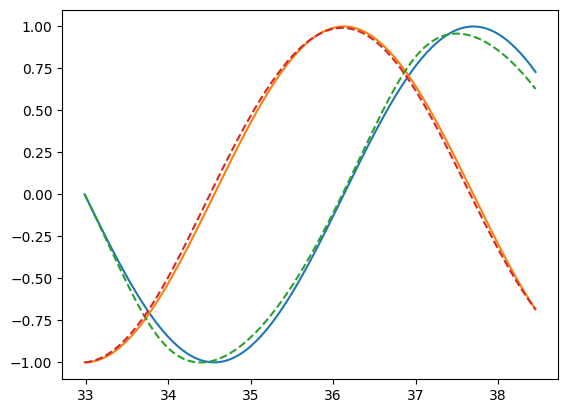

In [276]:
plt.plot(train_ts[0],train_ys[0,:,:])
y_pred = neural_ode_model(train_ts[0],train_ys[0,0,:][None, :])
plt.plot(train_ts[0],y_pred,'--')

In [263]:
opt_type = optax.adam(learning_rate=0.001)
optimizer = nnx.Optimizer(neural_ode_model, opt_type)

In [265]:
# Initialize train_losses
num_epochs = 2000
train_losses = jnp.zeros((num_epochs,))

y0 = train_ys[:, 0, :]  # Shape (4, 2)
y0 = y0[:, None, :]     # Reshape to (4, 1, 2)

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(neural_ode_model, optimizer, train_ts,y0,train_ys)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

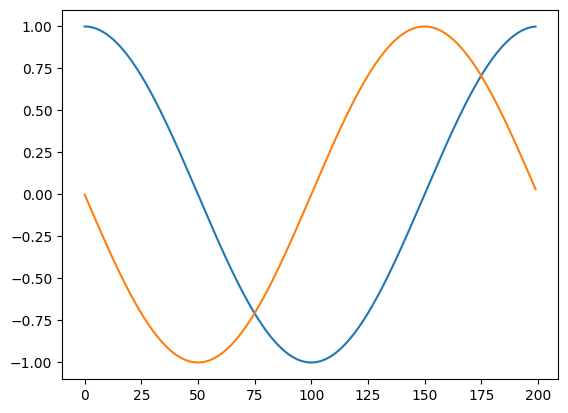

In [274]:
plt.plot(train_ys[1])

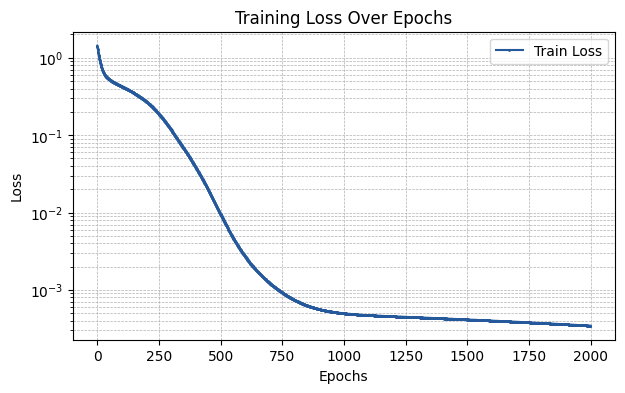

In [266]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

0.0017710928
0.003583727
0.0020483108
0.0009971184
0.0010716228
0.008400553


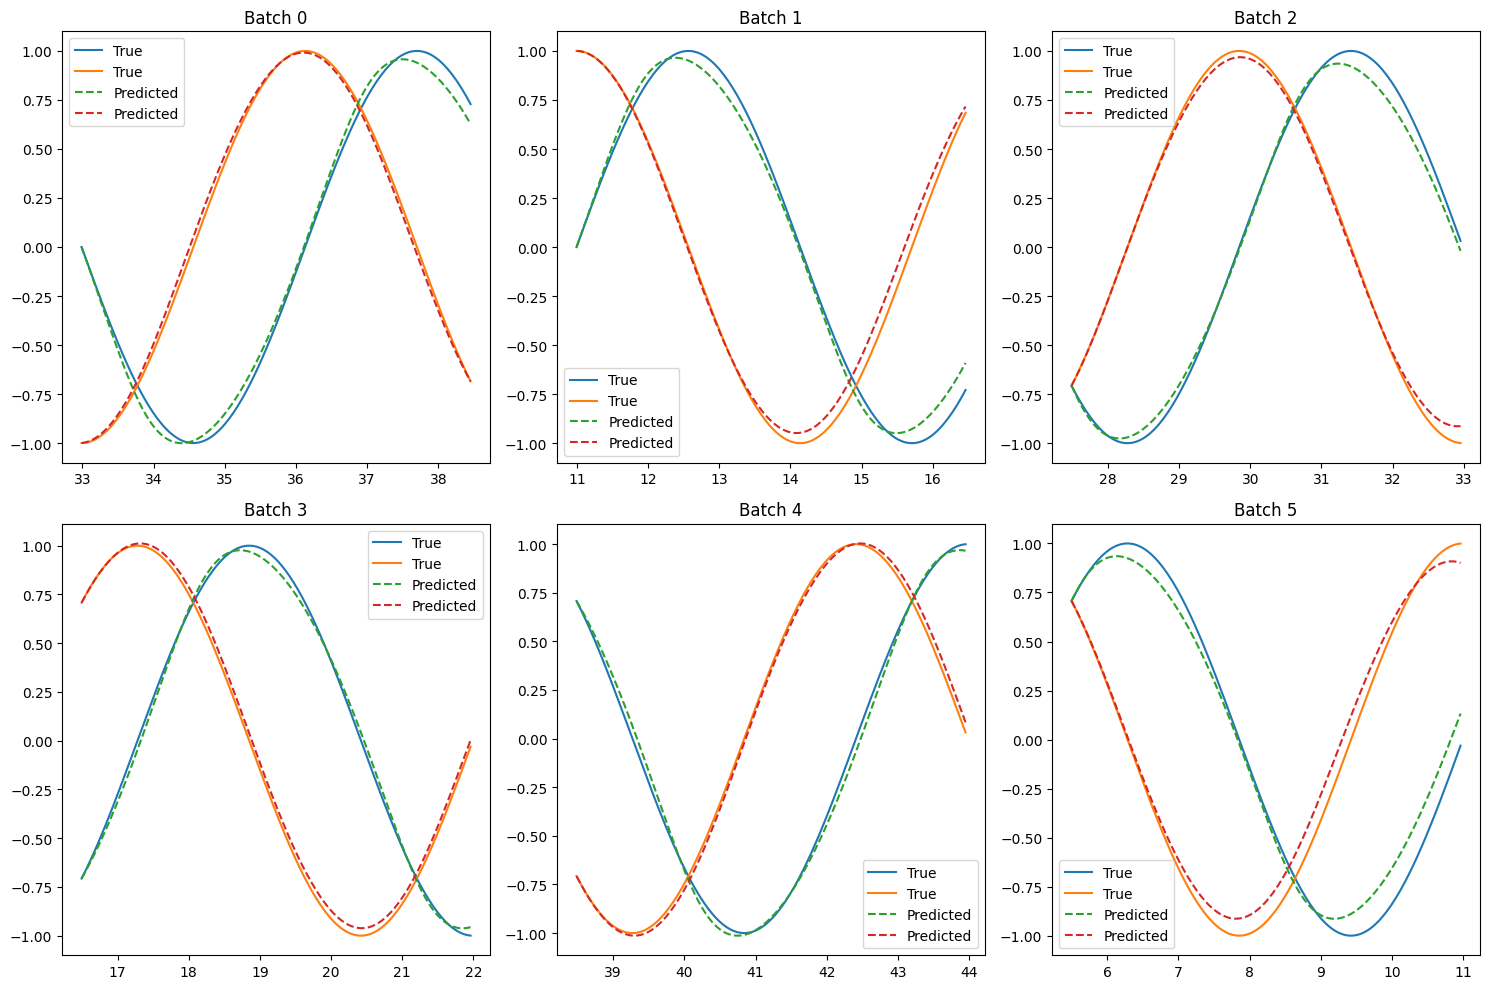

In [277]:
Ncols = 3
Nrows = int(np.ceil(train_ys.shape[0] / Ncols))

# Create subplots
fig, ax = plt.subplots(figsize=(Ncols * 5, Nrows * 5), ncols=Ncols, nrows=Nrows, squeeze=False)

for n in range(train_ys.shape[0]):
    i = n // Ncols  # Row index
    j = n % Ncols   # Column index
    
    # Plot ground truth
    ax[i, j].plot(train_ts[n], train_ys[n, :, :], label="True")
    
    # Predict using the neural ODE model
    y_pred = neural_ode_model(train_ts[n], train_ys[n, 0, :][None, :])
    ax[i, j].plot(train_ts[n], y_pred, '--', label="Predicted")

    print(jnp.mean((y_pred-train_ys[n, :, :])**2))
    
    # Add labels and legend
    ax[i, j].set_title(f"Batch {n}")
    ax[i, j].legend()

# Remove empty subplots if train_ys.shape[0] < Nrows * Ncols
for empty_idx in range(train_ys.shape[0], Nrows * Ncols):
    i = empty_idx // Ncols
    j = empty_idx % Ncols
    fig.delaxes(ax[i, j])

plt.tight_layout()
plt.show()

# KAN

In [283]:
# Initialize a KAN model
n_in = 2
n_out = 2
n_hidden = 6
seed = 42
layer_dims = [n_in, n_hidden, n_hidden, n_hidden, n_out]
req_params = {'k': 5}

KAN_model = KAN(layer_dims = layer_dims,
            layer_type = 'cheby',
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )
dF = dF_model(dy_dt = KAN_model)

neural_ode_model_KAN=NeuralODE(dF=dF)

y0 = jnp.array([[0.0,1.0]])
print(f"Testing {y0=} (shape: {y0.shape})") #(shape: (1, 2))
print(f"{KAN_model(y0)=} (shape: {KAN_model(y0).shape})") #(shape: (1, 2))
print(f"{dF(0.0,y0,None)=} (shape: {dF(0.0,y0,None).shape})") #(shape: (1, 2))
t=jnp.linspace(0.0,1.0)
print(f"(shape:{neural_ode_model_KAN(t,y0).shape}")  #ValueError: cannot select an axis to squeeze out which has size not equal to one, got shape=(50, 1, 2) and dimensions=(2,)



Testing y0=Array([[0., 1.]], dtype=float32) (shape: (1, 2))
KAN_model(y0)=Array([[0.09268187, 0.05731352]], dtype=float32) (shape: (1, 2))
dF(0.0,y0,None)=Array([[0.09268187, 0.05731352]], dtype=float32) (shape: (1, 2))


(shape:(50, 2)


In [284]:
opt_type = optax.adam(learning_rate=0.001)
optimizer = nnx.Optimizer(neural_ode_model_KAN, opt_type)

In [285]:
# Initialize train_losses
num_epochs = 2000
train_losses_kan = jnp.zeros((num_epochs,))

y0 = train_ys[:, 0, :]  # Shape (4, 2)
y0 = y0[:, None, :]     # Reshape to (4, 1, 2)

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(neural_ode_model_KAN, optimizer, train_ts,y0,train_ys)
    
    # Append the loss
    train_losses_kan = train_losses_kan.at[epoch].set(loss)

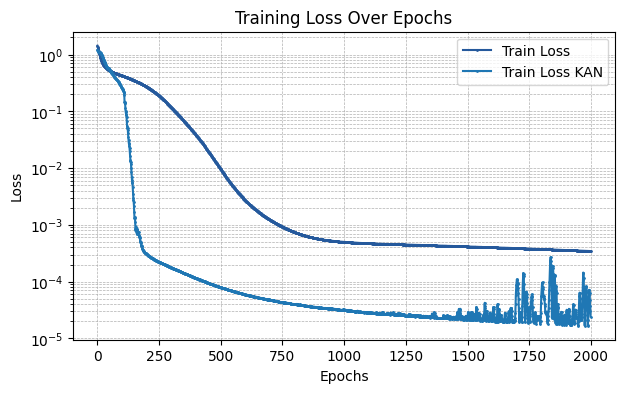

In [288]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)
plt.plot(np.array(train_losses_kan), label='Train Loss KAN', marker='o', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

1.8924546e-05
1.8843024e-05
2.6239986e-05
2.029985e-05
1.7166745e-05
1.756828e-05


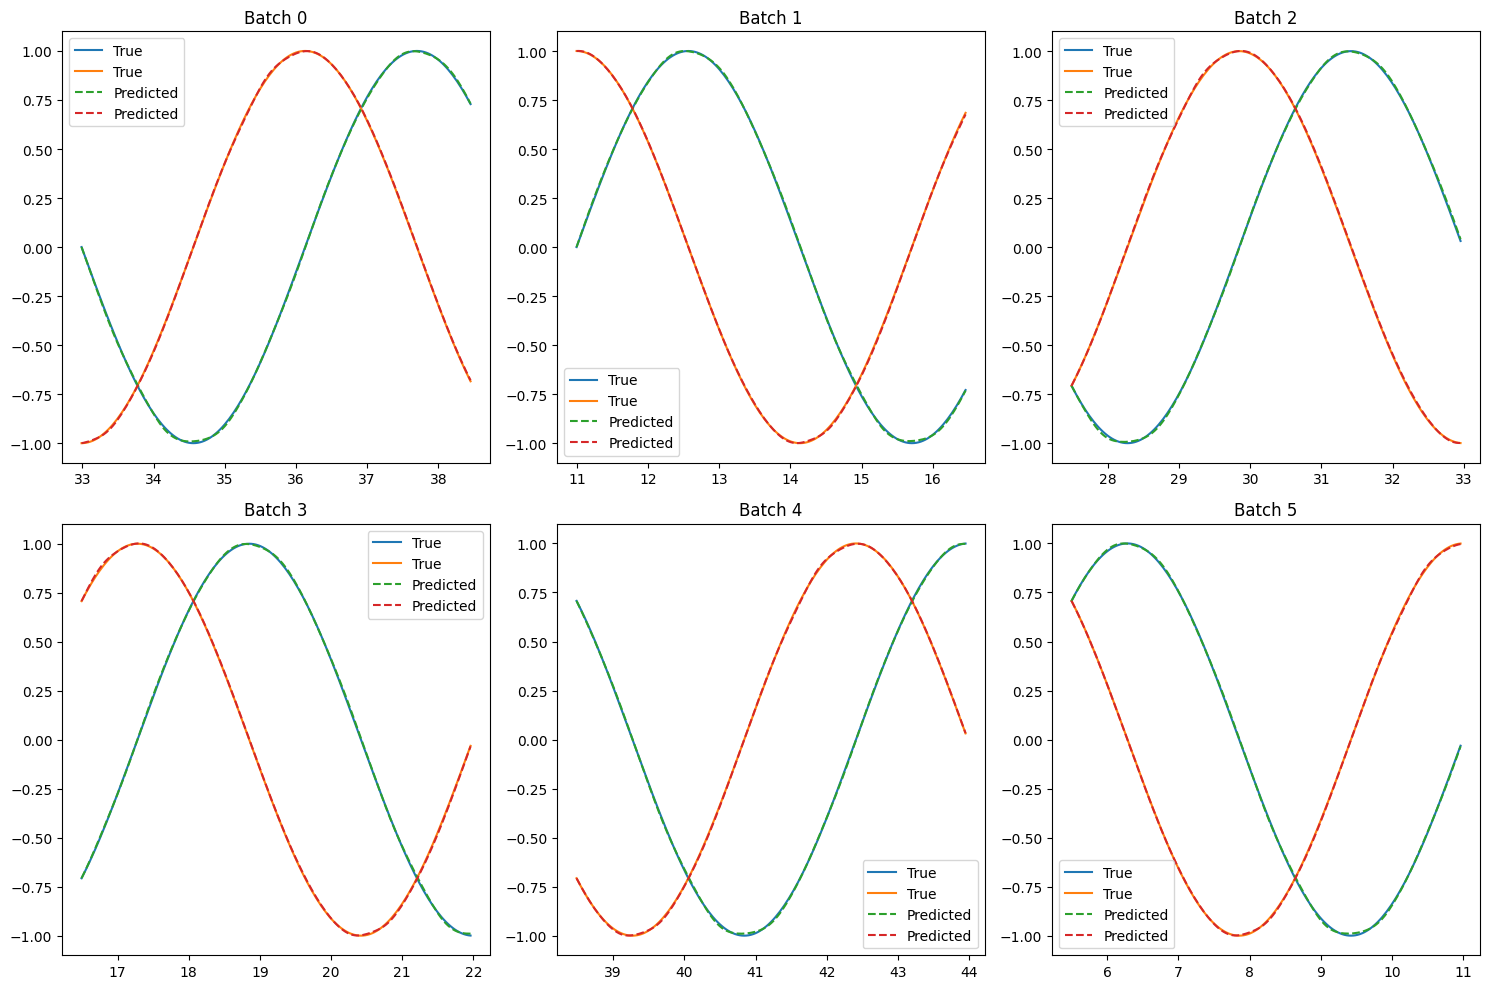

In [289]:
Ncols = 3
Nrows = int(np.ceil(train_ys.shape[0] / Ncols))

# Create subplots
fig, ax = plt.subplots(figsize=(Ncols * 5, Nrows * 5), ncols=Ncols, nrows=Nrows, squeeze=False)

for n in range(train_ys.shape[0]):
    i = n // Ncols  # Row index
    j = n % Ncols   # Column index
    
    # Plot ground truth
    ax[i, j].plot(train_ts[n], train_ys[n, :, :], label="True")
    
    # Predict using the neural ODE model
    y_pred = neural_ode_model_KAN(train_ts[n], train_ys[n, 0, :][None, :])
    ax[i, j].plot(train_ts[n], y_pred, '--', label="Predicted")

    print(jnp.mean((y_pred-train_ys[n, :, :])**2))
    
    # Add labels and legend
    ax[i, j].set_title(f"Batch {n}")
    ax[i, j].legend()

# Remove empty subplots if train_ys.shape[0] < Nrows * Ncols
for empty_idx in range(train_ys.shape[0], Nrows * Ncols):
    i = empty_idx // Ncols
    j = empty_idx % Ncols
    fig.delaxes(ax[i, j])

plt.tight_layout()
plt.show()